In [94]:
import pandas as pd
import numpy as np
import get_prices as hist
import tensorflow as tf
from preprocessing import DataProcessing
import pandas_datareader.data as pdr
import fix_yahoo_finance as fix
import matplotlib.pyplot as plt
fix.pdr_override()

In [95]:
def my_plot(history, head, save, model_name):
    loss = history.history['loss'][head:]
    val_loss = history.history['val_loss'][head:]
    epochs = range(head + 1, len(loss) + head + 1)
    plt.plot(epochs, loss, color='orange', label='Train')
    plt.plot(epochs, val_loss, color='green', label='Validation')
    plt.title(model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if save:
        plt.savefig("figures/" + model_name + ".{}head".format(head) + ".png", dpi=250)

In [96]:
model_base_name = "{}.{}ep.{}lr"

In [97]:
start = "2003-01-01"
end = "2018-01-01"

hist.get_stock_data("AAPL", start_date=start, end_date=end)
process = DataProcessing("stock_prices.csv", 1.0)
# process.gen_test(10)
process.gen_train(10)

[*********************100%***********************]  1 of 1 downloaded


/home/lab/isabella/stockprice_prediction/get_prices.py:32: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  stock_data.to_csv("stock_prices.csv")


In [98]:
XY_total = [(process.X_train[i], process.Y_train[i]) for i in range(len(process.X_train))]
np.random.shuffle(XY_total)

In [99]:
i_split = int(0.9 * len(XY_total))
XY_train = XY_total[:i_split]
X_train = np.asarray([t[0] for t in XY_train])
X_train = X_train.reshape((len(X_train), 10, 1)) / 200
Y_train = np.asarray([t[1] for t in XY_train]) / 200

XY_val = XY_total[i_split:]
X_val = np.asarray([t[0] for t in XY_val])
X_val = X_val.reshape((len(X_val), 10, 1)) / 200
Y_val = np.asarray([t[1] for t in XY_val]) / 200

# Models

In [7]:
from tensorflow.keras.layers import Convolution1D, LSTM, Dropout, Dense, MaxPooling1D, Flatten

## CNN model

In [22]:
epochs = 50
lr = ""
d_rate = 0.4
n_filters = 64
kernel_size = 2

In [23]:
model_name = model_base_name.format(
    "CNN",
    epochs,
    lr
)

In [24]:
model = tf.keras.Sequential()
# model.add(Dense(128, activation='relu',input_shape=(10, 1)))
model.add(Convolution1D(input_shape=(10, 1),
                        filters=n_filters, 
                        kernel_size=kernel_size,
                        activation='relu', 
#                         padding='valid', 
#                         strides=1
                       )
         )
model.add(MaxPooling1D(pool_size=1))
# model.add(tf.keras.layers.Convolution1D(20))
model.add(Dropout(d_rate))
model.add(Flatten())
model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
model.compile(optimizer="adam", loss="mean_squared_error")

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 9, 64)             192       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 577       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))

Train on 3383 samples, validate on 376 samples
Epoch 1/50
3383/3383 [==============================] - 1s 232us/sample - loss: 0.0066 - val_loss: 3.4237e-04
Epoch 2/50
3383/3383 [==============================] - 0s 145us/sample - loss: 0.0017 - val_loss: 1.8463e-04
Epoch 3/50
3383/3383 [==============================] - 1s 148us/sample - loss: 0.0013 - val_loss: 1.7402e-04
Epoch 4/50
3383/3383 [==============================] - 0s 145us/sample - loss: 9.5084e-04 - val_loss: 1.3294e-04
Epoch 5/50
3383/3383 [==============================] - 1s 149us/sample - loss: 9.3139e-04 - val_loss: 1.0227e-04
Epoch 6/50
3383/3383 [==============================] - 1s 148us/sample - loss: 8.4211e-04 - val_loss: 1.0001e-04
Epoch 7/50
3383/3383 [==============================] - 1s 149us/sample - loss: 8.3091e-04 - val_loss: 1.1552e-04
Epoch 8/50
3383/3383 [==============================] - 0s 147us/sample - loss: 7.5093e-04 - val_loss: 1.5443e-04
Epoch 9/50
3383/3383 [==============================]

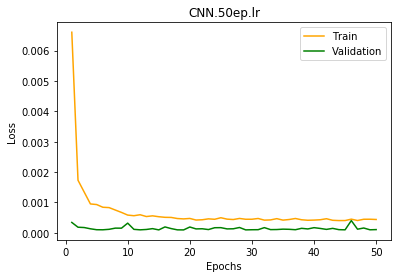

In [27]:
my_plot(history, 0, True, model_name)

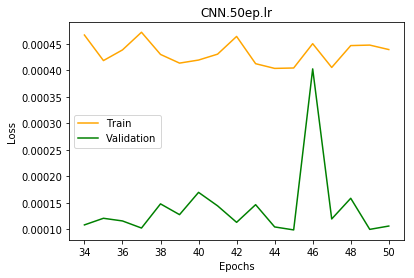

In [28]:
my_plot(history, 33, True, model_name)

## LSTM model

In [129]:
epochs = 50
lr = 0.00001

In [130]:
adam = tf.keras.optimizers.Adam(lr=lr)

In [131]:
model_name = model_base_name.format(
    "LSTM",
    epochs,
    lr
)

In [132]:
model = tf.keras.Sequential()
model.add(LSTM(20, input_shape=(10, 1), return_sequences=True))
model.add(LSTM(20))
model.add(Dense(1, activation=tf.nn.relu))

model.compile(optimizer=adam, loss="mean_squared_error")

In [133]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 10, 20)            1760      
_________________________________________________________________
lstm_29 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))

Train on 3383 samples, validate on 376 samples
Epoch 1/50
3383/3383 [==============================] - 9s 3ms/sample - loss: 0.0776 - val_loss: 0.0737
Epoch 2/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0698 - val_loss: 0.0661
Epoch 3/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0623 - val_loss: 0.0587
Epoch 4/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0552 - val_loss: 0.0519
Epoch 5/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0485 - val_loss: 0.0453
Epoch 6/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0422 - val_loss: 0.0392
Epoch 7/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0364 - val_loss: 0.0337
Epoch 8/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0311 - val_loss: 0.0287
Epoch 9/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0265 - val_loss: 0.0244
Epoch 10/50
3383/

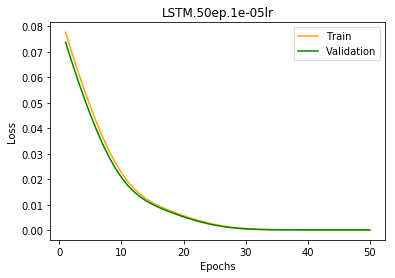

In [135]:
my_plot(history, 0, True, model_name)

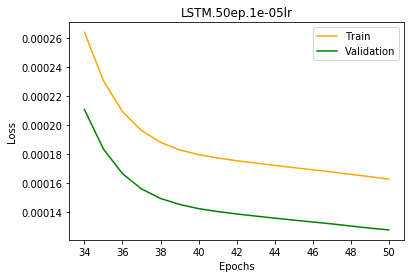

In [136]:
my_plot(history, 33, True, model_name)

## CNN + LSTM model

In [155]:
epochs = 35
lr = 0.00001

In [156]:
# adam = tf.keras.optimizers.Adam(lr=lr)
adam = tf.keras.optimizers.Adam()

In [157]:
model_name = model_base_name.format(
    "CNN + LSTM",
    epochs,
    lr
)

In [158]:
model = tf.keras.Sequential()
model.add(Dense(128, input_shape=(10, 1), activation=tf.nn.relu))
model.add(Convolution1D(filters=24, 
                        kernel_size=1,
                        activation='relu'
                       )
         )
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(
                        input_shape=(10, 1),
                        filters=48, 
                        kernel_size=1,
                        activation='relu'
                       )
         )
model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.4))
model.add(LSTM(40, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(32, activation=tf.nn.relu))
model.add(Dense(1, activation=tf.nn.relu))

model.compile(optimizer=adam, loss="mean_squared_error")

In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 10, 128)           256       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 10, 24)            3096      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 5, 24)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5, 48)             1200      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 2, 48)             0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 2, 40)             14240     
_________________________________________________________________
lstm_33 (LSTM)               (None, 32)                9344      
__________

In [160]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=128, validation_data=(X_val, Y_val))

Train on 3383 samples, validate on 376 samples
Epoch 1/35
3383/3383 [==============================] - 6s 2ms/sample - loss: 0.0599 - val_loss: 0.0308
Epoch 2/35
3383/3383 [==============================] - 1s 156us/sample - loss: 0.0112 - val_loss: 0.0014
Epoch 3/35
3383/3383 [==============================] - 1s 158us/sample - loss: 8.7897e-04 - val_loss: 3.3418e-04
Epoch 4/35
3383/3383 [==============================] - 1s 176us/sample - loss: 2.0367e-04 - val_loss: 1.1109e-04
Epoch 5/35
3383/3383 [==============================] - 1s 172us/sample - loss: 1.2897e-04 - val_loss: 1.0302e-04
Epoch 6/35
3383/3383 [==============================] - 1s 175us/sample - loss: 1.2486e-04 - val_loss: 1.0141e-04
Epoch 7/35
3383/3383 [==============================] - 1s 179us/sample - loss: 1.2800e-04 - val_loss: 1.0273e-04
Epoch 8/35
3383/3383 [==============================] - 1s 173us/sample - loss: 1.2757e-04 - val_loss: 1.0870e-04
Epoch 9/35
3383/3383 [==============================] - 1s 

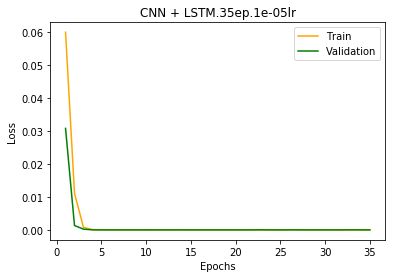

In [161]:
my_plot(history, 0, True, model_name)

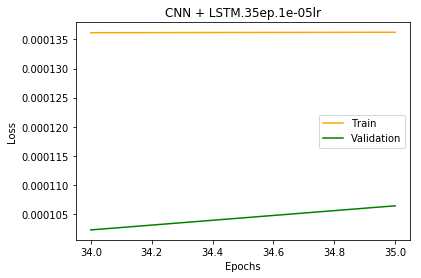

In [162]:
my_plot(history, 33, True, model_name)

# Prediction

In [29]:
test_csv = "stock_prices_test.csv"
def save_stock_data(ticker, start_date, end_date):
    i = 1
    try:
        all_data = pdr.get_data_yahoo(ticker, start_date, end_date)
    except ValueError:
        print("ValueError, trying again")
        i += 1
        if i < 5:
            time.sleep(10)
            get_stock_data(ticker, start_date, end_date)
        else:
            print("Tried 5 times, Yahoo error. Trying after 2 minutes")
            time.sleep(120)
            get_stock_data(ticker, start_date, end_date)
    stock_data = all_data["Adj Close"]
    stock_data.to_csv(test_csv)

In [34]:
def my_pred_plot(pred, test, save):
    samples = range(1, len(test) + 1)
    plt.plot(samples, pred, color='orange', label='Prediction')
    plt.plot(samples, test, color='green', label='Actual value')
    plt.title(model_name)
    plt.xlabel('Samples')
    plt.ylabel('Stock value')
    plt.legend()
    if save:
        plt.savefig("figures/" + model_name + ".pred" + ".png", dpi=250)

In [163]:
save_stock_data("AAPL", "2016-03-01", "2016-09-30")
process_test = DataProcessing("stock_prices_test.csv", 1.0)
process_test.gen_train(10)
X_test = process_test.X_train.reshape((len(process_test.X_train), 10, 1)) / 200
Y_test = process_test.Y_train

[*********************100%***********************]  1 of 1 downloaded


/home/lab/isabella/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [164]:
Y_predict = model.predict(X_test)*200

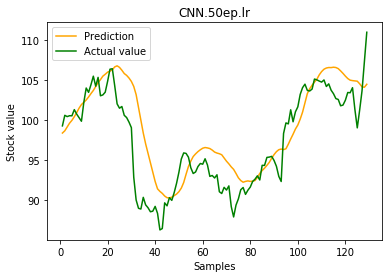

In [37]:
# CNN
my_pred_plot(Y_predict[0:], Y_test[0:], False)

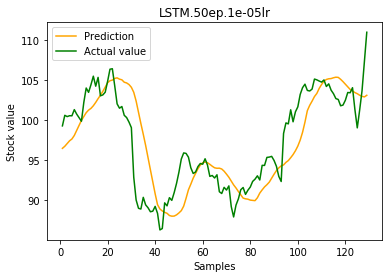

In [139]:
# LSTM
my_pred_plot(Y_predict[0:], Y_test[0:], False)

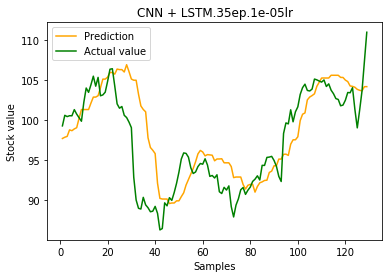

In [165]:
# CNN + LSTM 
my_pred_plot(Y_predict[0:], Y_test[0:], False)

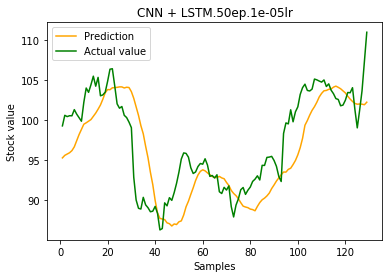

In [118]:
# CNN + LSTM 
my_pred_plot(Y_predict[0:], Y_test[0:], False)

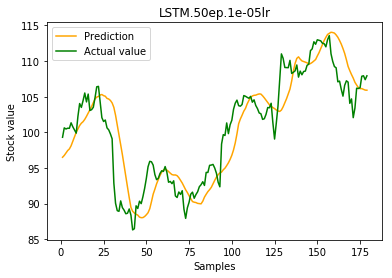

In [143]:
# CNN + LSTM 
my_pred_plot(Y_predict[0:], Y_test[0:], False)